## Quantum energy states of a twisted bilayer superconductor

I work in an area of Physics which deals with quantum phases of matter such as superconductors, topological insulators, Bose-Einstein condensates and so on. Recently, it was revealed in state-of-the-art experiments that new and exotic phases of matter (absent for the untwisted system) are realized when a couple of thin (atomic size) layers of a material are stacked on top of each other with a relative twisted orientation, propelled by the findings in $twisted~bilayer~graphene$. In particular, many of the phases found in such studies show non-trivial topological characters. Now, it has been a long-standing issue to find a decisive and controlled realization of a superconductor which also carries topological behavior, called topological superconductors. These are also proposed as potential platform to perform fault tolerant topological quantum computing. Hence, motivated by these discoveries and prospects, we study a recent proposition to find topological superconductivity by twisting two layers of planner superconductors. **Below is a snapshot of the code we use, which should provide adequate evidence of my python coding skills as well as ability to exploit it in solving intricate problems and simulate complex mathematical models.**

Each superconducting layer is a (periodic) square lattice. Two such square lattice layers are stacked onto each other, so that lattice-sites of one layer are aligned with the other's. Then one layer is rotated about one of its sites. For simplicity, the rotation angle ($\theta$) is taken so that the combined system after rotation is also periodic (Moire periodicity) along the planar direction. It will again appear as a square lattice when seen from top, but with enlarged size of the periodic unit (unit-cell), and each unit-cell contains several lattice-sites of the two layers situated at different coordinates inside the unit-cell (Plot under Sec-2). The first goal is to determine the Hamiltonian ($H$) matrix corresponding to this set-up. 

Let the lattice sites of the twisted bilayer system be labeled as $i=1,2,\ldots$ . Then we assign some value for the matrix element $H_{2i,2j}$ based on distance between sites-$i,j$. The factor of $2$ comes from 2 internal degrees of freedom situated within each lattice site (these are actually atoms carrying spins, electronic orbitals etc, $2$ of which are relevant here). Since the system is periodic, we can Fourier transform the Hamiltonian and represent it in the 2D Fourier space $H(\mathbf{k})\equiv H(k_x,k_y)$. Each $H(\mathbf{k})$ is a $2N\times 2N$ matrix, where $N$ is the number of sites falling inside a unit-cell. In order to determine $H(\mathbf{k})$, for each of these $N$ sites we need to find which sites are its nearest neighbor (NN), next nearest neighbor (NNN), or, fall within a threshold distance, along with their layer ancestry, and all this is done in the twisted system. This is shown by the bold lines in the plots in Sec-2.

Finally, the topological behavior of the system is a property of its quantum energy states. An important requirement is having a clear energy gap in the energy spectrum. We find it in the plot of Sec-4.

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rc
import scipy.linalg as la1
import scipy.sparse.linalg as la
from scipy.sparse import csr_matrix
#import numpy.linalg as la1
from numpy import linalg as LA
na=np.array
from scipy.sparse import kron,diags
pr=print
from scipy.spatial import cKDTree
from scipy.spatial import KDTree
import math
from math import*

import xml.etree.ElementTree as ET

import time

### 1. Charting the site locations and their relative separation in the twisted bilayer lattice

In [2]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from numpy import linalg as LA
from scipy import spatial

def updiag(hops): #It makes all hopping listed in hops, to start from a site that has index<the destination site. When this is not satisfied in the input "hops", the function just swaps the respective hopping and also changes the respective \vec{G} at hop[3] to -vec{G}.
    for hop in hops: # Note, it doesn't change hop[2], the bonding directionality, be careful of that.
        hopfrom=hop[0]
        hopto=hop[1]
        if hopfrom > hopto:
            hop[0]=hopto
            hop[1]=hopfrom
            hop[3][0]=-1*hop[3][0]
            hop[3][1]=-1*hop[3][1]
    return hops

def sqlattice(N,M):
    return np.array([x for x in itertools.product(np.arange(-1*N,N), np.arange(-1*M,M))])

def translate(lattice,translation_x,translation_y):
    translation=np.array([translation_x,translation_y])
    lattice=lattice+translation
    return lattice

def rotate(lattice,theta): # Rotates each point on the site counter-clockwise by theta.
    '''
    rotates a 2D lattice (array) CCW by angle \theta.
    '''
    rot= np.matrix([[np.cos(theta),-1.0*np.sin(theta)],[np.sin(theta),np.cos(theta)]])
    return np.einsum("ij,aj->ai",rot,lattice)

def plotlat(fig,lt,col,alph=1):
    '''
    plots the lattice
    '''
    x,y = lt.T
    fig.scatter(x,y,alpha=alph,color=col)#,s=10)

def generate(a,d,vec,interlayerNNnumber,interlayerNNdistance,offsetamount=0.0,plothoppingmaps=True,rho=0.39,nx=1,ny=1): #Definition of arguments can be found in solver.py: There, the arguments input used when calling "generate" are explained.
    ucboundaryshift=a*0.1   #uc is short for unit-cell.
    
    global dict1,dict2,allhops
    #nx,ny=1,1 ## stack primitive unit cell: 1-1 no stacking.
    #vec=[3,8]
    #offsetamount=0.0
    #a=1.0
    #interlayerNNnumber=300
    #interlayerNNdistance=3.2
    #d=2.22
    #rho=0.39
    
    v1,v2=vec
    
    plothops=False ## plots the hopping map as they are generated. (random numbering)
    
    lat=sqlattice(30,30)
    
    ## HERE WE DEFINE THE UNITCELL AND CREATE THE LAYERS.
    unitcellsize=np.sqrt(vec[0]**2+vec[1]**2)
    layer1=rotate(lat,np.arctan(vec[0]/vec[1])) #blue - to the left
    layer2=rotate(lat,-1.0*np.arctan(vec[0]/vec[1])) #orange to the right
    ### translate layer 2
    offsetangle=np.pi/4-np.arctan(vec[0]/vec[1])
    layer2=translate(layer2,offsetamount*a*0.5*np.sqrt(2)*np.cos(offsetangle),offsetamount*a*0.5*np.sqrt(2)*np.sin(offsetangle))
    
    layer1=layer1+np.array([ucboundaryshift,ucboundaryshift])
    layer2=layer2+np.array([ucboundaryshift,ucboundaryshift])
    
    #layer1=np.round(layer1,2)
    #layer2=np.round(layer2,10)
    
    largeruclimits=10.0
    
    unitlayer1=[] # Sites (coordinates of the sites) of layer1 falling inside the 2D region [0,uc_size_x]*[0,uc_size_y]
    unitlayer2=[]
    largeruc1=[] # Sites (coordinates of the sites) of layer1 falling inside the 2D region [-largeruclimits,uc_size_x+largeruclimits]*[-largeruclimits,uc_size_y+largeruclimits], a larger range than the Moire unitcell size
    largeruc2=[]
    
    uc_size_x=nx*unitcellsize
    uc_size_y=ny*unitcellsize
    
    '''
    def inunit(x,y):
        if a*-0.01 <= x < uc_size_x-a*0.01 and a*-0.01 <= y < uc_size_y-a*0.01: return True
        else: return False
    '''
    def inunit(x,y):
        if 0 <= x < uc_size_x and 0 <= y < uc_size_y: return True
        else: return False
    
    
    def bonddirection(layer,dx,dy):
        if layer == 1: # Remember, layer1 is rotated counter-clockwise by theta.
            if dx < 0 and dy>0: return "+y"
            if dx < 0 and dy<0: return "-x"
            if dx > 0 and dy<0: return "-y"
            if dx > 0 and dy>0: return "+x"
        if layer == 2: # And, layer2 is rotated clockwise by theta.
            if dx > 0 and dy>0: return "+y"
            if dx < 0 and dy>0: return "-x"
            if dx < 0 and dy<0: return "-y"
            if dx > 0 and dy<0: return "+x"
            
    def bonddirection(layer,dx,dy): # My version of above function, to distill NNN hopping directions from NN ones.
        th=((-1)**layer)*np.arctan(vec[0]/vec[1]) # Rotating back layer-1 by -theta, layer-2 by +theta.
        dx1,dy1=dx*cos(th)-dy*sin(th),dx*sin(th)+dy*cos(th)
        
        if abs(dx1)<1e-6:
            if dy1>0.01: return "+y"
            elif dy1<-0.01: return "-y"
            else:
                return "Error"
                print("error in my bonddirection code:x=0")
        elif abs(dy1)<1e-6:
            if dx1>0.01: return "+x"
            elif dx1<-0.01: return "-x"
            else: 
                return "Error"
                print("error in my bonddirection code:y=0")
        elif dx1>0.01:
            if dy1>0.01: return "+x+y"
            elif dy1<-0.01: return "+x-y"
            else: 
                return "Error"
                print("error in my bonddirection code:x>0")
        elif dx1<-0.01:
            if dy1>0.01: return "-x+y"
            elif dy1<-0.01: return "-x-y"
            else: 
                return "Error"
                print("error in my bonddirection code:x<0")
        else: 
            return "Error"
            print("error in my bonddirection code:find")
    
            
    for pt in layer1:
        if inunit(pt[0],pt[1]):
            unitlayer1.append(pt)
        if -1.0*largeruclimits*a <= pt[0] < uc_size_x + a*largeruclimits and -1.0*largeruclimits*a <= pt[1]< uc_size_y + a*largeruclimits:
            largeruc1.append(pt)
    for pt in layer2:
        if inunit(pt[0],pt[1]):
            unitlayer2.append(pt)
        if -1.0*largeruclimits*a <= pt[0] < uc_size_x + a*largeruclimits and -1.0*largeruclimits*a <= pt[1]< uc_size_y + a*largeruclimits:
            largeruc2.append(pt)
    
    unitlayer1=np.array(unitlayer1)
    unitlayer2=np.array(unitlayer2)
    largeruc1=np.array(largeruc1)
    largeruc2=np.array(largeruc2)
    
    def plotbase(fig):
        ### PLOT UNITCELL -
        ax = fig.add_subplot(1, 1, 1,adjustable='box', aspect=1)
        #plt.xlim(0,uc_size_x)
        #plt.ylim(0,uc_size_y)
        plotlat(ax,largeruc1,"C0",alph=0.4)
        plotlat(ax,largeruc2,"C1",alph=0.4)
        plotlat(ax,unitlayer1,"C0")
        plotlat(ax,unitlayer2,"C1")
        rect = plt.Rectangle((0,0), uc_size_x, uc_size_y, color='k', alpha=0.1)
        ax.add_patch(rect)
    
    largeructree1=spatial.cKDTree(largeruc1)
    largeructree2=spatial.cKDTree(largeruc2)
    
    def get_hoppings(layer,neighbor_range=1):
        ## THIS CREATES THE NEAREST NEIGHBOR HOPPINGS FOR A GIVEN LAYER.
        hops=[]
        plothops=False
        if layer == 1: 
            largeruc=largeruc1
            largeructree = largeructree1
        if layer == 2 or layer ==12: 
            largeruc=largeruc2
            largeructree = largeructree2
        if plothops:
            fig=plt.figure()
            plotbase(fig)
        if layer ==1 or layer ==2:
            if neighbor_range == 1:
                NNhoppings=largeructree.query_pairs(1.05)
                layer_hoppings=NNhoppings
            if neighbor_range == 2:
                NN_NNNhoppings=largeructree.query_pairs(1.05*np.sqrt(2))
                NNhoppings=largeructree.query_pairs(1.05)
                difference=NN_NNNhoppings-NNhoppings
                layer_hoppings=difference
            if neighbor_range != 1 and neighbor_range != 2:
                print ("range not available.")
                return 
            for hop in layer_hoppings:
                depx,depy=largeruc[hop[0]] # hop[0] is the index of the departure point of the hopping, depx is its coordiates after twist
                desx,desy=largeruc[hop[1]] # Same as last line, but for the destination site of the hopping.
                dx=desx-depx
                dy=desy-depy
                dep_in=inunit(depx,depy)
                des_in=inunit(desx,desy)
                if dep_in:
                    bdirection=bonddirection(layer,dx,dy)
                    reciprocal=[int(desx//(uc_size_x)),int(desy//(uc_size_y))]
                    if plothops:
                        plt.text(depx+0.1*a,depy+0.1*a,hop[0]) #plot the old labeling
                        if des_in: plt.text(desx+0.1*a,desy+0.1*a,hop[1]) #plot the old labeling
                    
                        plt.arrow(depx,depy,dx,dy,width=0.02,length_includes_head=True,alpha=0.5)
                        plt.text(depx+0.5*dx,depy+0.5*dy,bdirection,color='blue')
                    
                    hops.append([hop[0],hop[1],bdirection,reciprocal,[layer,layer]])
                    #print ([hop[0],hop[1],bdirection,reciprocal,[layer,layer]])
        if layer == 12:        
            def findNNBS(siteindex,closest_n,maxdistance):
                largeructree=spatial.cKDTree(largeruc2)
                hopfrom=largeruc1[siteindex]
                NNBS=np.array(largeructree.query(hopfrom,closest_n)).T
                
                if closest_n == 1:
                    NNBS=np.array([NNBS])
                resNNBS=[]
                for interhop in NNBS:                    
                    if interhop[0] <= maxdistance*a+10**(-8):
                        resNNBS.append(interhop)
                return np.array(resNNBS)
            
            
            for siteindex in range(len(largeruc1)):
                hopfrom=largeruc1[siteindex]
                NNBS=findNNBS(siteindex,closest_n=interlayerNNnumber,maxdistance=interlayerNNdistance)
                for nneighbor in NNBS:
                    projecteddistance=nneighbor[0]
                    targetsite=int(nneighbor[1])
                    depx,depy=hopfrom
                    desx,desy=largeruc2[targetsite]
                    dx=desx-depx
                    dy=desy-depy
                    projecteddistance=np.sqrt(dx**2+dy**2)
                    distance=np.sqrt(projecteddistance**2 + d**2)

                    #couplingfactor=np.exp(rho/d)*np.exp(-distance/rho)
                    couplingfactor=np.exp(-1.0*(distance-d)/rho)

            
                    palpha=0.1
                    #reciprocal=[int(desx//(unitcellsize*0.999)),int(desy//(unitcellsize*0.999))]
                    reciprocal=[int(desx//(uc_size_x)),int(desy//(uc_size_y))]
                    if inunit(depx,depy):
                        palpha=0.4
                        if plothops:
                            plt.text(depx+0.05*a,depy+0.05*a,siteindex) #plot the old labeling
                            plt.text(desx+0.05*a,desy-0.05*a,targetsite) #plot the old labeling
                        hops.append([siteindex,targetsite,couplingfactor,reciprocal,[1,2]]) #the output for interlayer hopping
                        #print ("l1 site "+str(siteindex)+" to l2 site "+str(targetsite), reciprocal)
                        if plothops: plt.arrow(depx,depy,dx,dy,width=0.02*couplingfactor,length_includes_head=True,alpha=palpha)
             
        newhops=[]
        i=0
        for hop in hops:
            rec=hop[3]
            target=hop[1]
            if rec != [0,0]:
                des=hop[1] #this is sticking out of the BZ.
                subtract=np.array([rec[0]*uc_size_x,rec[1]*uc_size_y])
                intheBZ=largeruc[des]-subtract # get the coordinates of this point and subtract the reciprocal vector 
                #intheBZ=largeruc[des]-np.array(rec)*unitcellsize # get the coordinates of this point and subtract the reciprocal vector 
                #now find the closest point IN the unit cell
                if not inunit(intheBZ[0],intheBZ[1]):
                    print (largeruc[des],"NOT BACK IN THE BZ!", intheBZ)
                    print (hop)
                target=largeructree.query(intheBZ,1)[1]
                #print (hop[0],hop[1]," goes back to",hop[0],target) 
                ## modify the hopping accordingly: np.array([hop[0],hop[1],bdirection,reciprocal,layer])
            #print ([hop[0],target,hop[2],hop[3],hop[4]])
            newhops.append([hop[0],target,hop[2],hop[3],hop[4]])
            i+=1
        return newhops
    
    
    def hopdict(oldhops):
        ##'relabels hoppings'
        hopdictionary=[{},{}]
        count=[0,0]
        for hop in oldhops:
            oldindex_from=hop[0]
            layer_from=hop[4][0]-1
            oldindex_to=hop[1]
            layer_to=hop[4][1]-1
            ## now check if these exist in
            fromdict=hopdictionary[layer_from]
            todict=hopdictionary[layer_to]
            if oldindex_from not in fromdict.keys():
                hopdictionary[layer_from][oldindex_from]=count[layer_from]
                count[layer_from]+=1
            if oldindex_to not in todict.keys():
                hopdictionary[layer_to][oldindex_to]=count[layer_to]
                count[layer_to]+=1
        return hopdictionary
    
    
    hops1=get_hoppings(1,1) #NN hopping in layer 1
    hops2=get_hoppings(2,1)
    hops11=get_hoppings(1,2) #NNN hopping in layer 1
    hops22=get_hoppings(2,2)
    hops12=get_hoppings(12,1)

    
    #allhops=np.concatenate((hops1,hops2,hops11,hops22,hops12)) 
    allhops=hops1+hops2+hops11+hops22+hops12
    
    labeldict=hopdict(allhops)
    singlelayerbasissize=(v1**2+v2**2)
    dict1=labeldict[0]
    dict2=labeldict[1]
    
    for label in dict2.keys():
        dict2[label] += singlelayerbasissize
    for hop in hops1:
        hop[0],hop[1]=dict1[hop[0]],dict1[hop[1]]
        if hop[2] == None:
            if hop[3] == [1,0]: hop[2] = "+x"
            if hop[3] == [0,1]: hop[2] = "+y"
    for hop in hops2:
        hop[0],hop[1]=dict2[hop[0]],dict2[hop[1]]
        if hop[2] == None:
            if hop[3] == [1,0]: hop[2] = "+x"
            if hop[3] == [0,1]: hop[2] = "+y"
    for hop in hops12:
        hop[0],hop[1]=dict1[hop[0]],dict2[hop[1]]
        if hop[2] == None:
            if hop[3] == [1,0]: hop[2] = "+x"
            if hop[3] == [0,1]: hop[2] = "+y"
    
    ## DO THE SAME FOR NNN HOPPINGS
    
    for hop in hops11:
        hop[0],hop[1]=dict1[hop[0]],dict1[hop[1]]
    for hop in hops22:
        hop[0],hop[1]=dict2[hop[0]],dict2[hop[1]]
    
    def get_key(val,my_dict): 
        for key, value in my_dict.items(): 
             if val == value: 
                 return key 
        return "key doesn't exist"
               
    def plothopmap(hopstoplot,plottitle):
        fig=plt.figure()
        plotbase(fig)
        
        for hop in hopstoplot:
            if hop[4][0] == 1: 
                luc=largeruc1
                depdict=dict1
                textcolor="C0"
            if hop[4][0] == 2: 
                luc=largeruc2
                depdict=dict2
                textcolor="C1"
            hopindex=get_key(hop[0],depdict)
            depx,depy=luc[hopindex]
            if hop[4][1] == 1: 
                luc=largeruc1
                desdict=dict1
            if hop[4][1] == 2: 
                luc=largeruc2
                desdict=dict2
            hopindex=get_key(hop[1],desdict)
            desx,desy=luc[hopindex]+np.array(hop[3])*unitcellsize
            dx=desx-depx
            dy=desy-depy
            dep_in=inunit(depx,depy)
            des_in=inunit(desx,desy)
            normalwidth=0.03
            if hop[4][0] != hop[4][1]:
                normalwidth=0.04*hop[2]
                if des_in:
                    plt.text(desx+0.05*a,desy-0.05*a,hop[1],color="black")
            if dep_in:
                plt.text(depx+0.05*a,depy+0.05*a,hop[0],color=textcolor)
                
                if not (dx == 0.0 and dy == 0.0):
                    plt.arrow(depx,depy,dx,dy,width=normalwidth,length_includes_head=True,alpha=0.2)
        plt.xlim(-1.2*uc_size_x,2.2*uc_size_x)
        plt.ylim(-1.2*uc_size_y,2.2*uc_size_y)
        plt.title(plottitle)

    if plothoppingmaps:
        plothopmap(hops1,"NN terms, layer 1")
        plothopmap(hops2,"NN terms, layer 2")
        plothopmap(hops11,"NNN terms, layer 1")
        plothopmap(hops22,"NNN terms, layer 2")
        plothopmap(hops12,"interlayer terms, layer 1-> 2")

    return hops1,hops2,hops12,hops11,hops22


### 2. Unit-cell (shaded region) and periodicity of the twisted system. 

Top view of the twisted set-up. Blue sites belong to layer-1 and orange ones to layer-2. The brown sites represent a site of layer-2 sitting atop of another from layer-1. In the plot, both layer-1 and layer-2 are rotated by equal ($\pm\theta/2$) and opposite way. The lines represent lattice sites which are NN, NNN or, fall within a certain distance from each other, and their layer of origin.

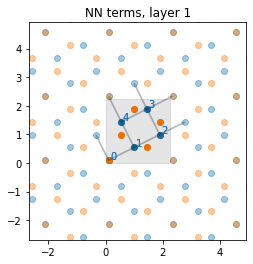

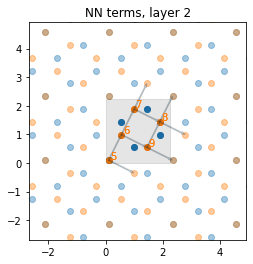

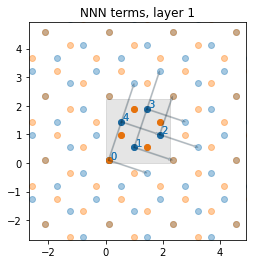

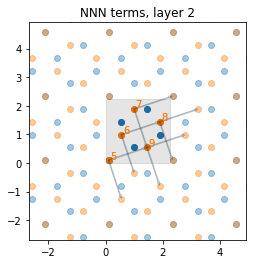

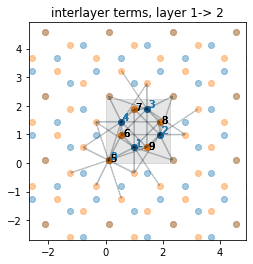

In [4]:
hops1,hops2,hops12,hops11,hops22 = generate(a=1.0,d=2.22,vec=[1,2],interlayerNNnumber=9,interlayerNNdistance=7.8,offsetamount=0,plothoppingmaps=True,rho=0.39,nx=1,ny=1)
#print(hops1)
#print(hops2)
hops1=updiag(hops1)
hops2=updiag(hops2)
hops11=updiag(hops11) ## next nearest neighbors
hops22=updiag(hops22) ## next nearest neighbors
intralayerhops=hops1+hops2 #combine the two lists.

### 3. Building the Hamiltonian matrix $H(\mathbf{k})$ of the model

In [3]:
ONCLUSTER=False  ## enable this only for cluster use

import numpy as np
import matplotlib
if ONCLUSTER:
    matplotlib.use('Agg')
import matplotlib.pyplot as plt
from numpy import linalg as LA
import os,sys
import multiprocessing
import gc
import time

##################################################################
##################################################################

M=80 # specifies the BZ mesh - (M x M k-point grid) 

plot_op_iterations = True # visual for iterations and tracking convergence.
# it shows the value of each order parameter living in bonds between
# sites (blue: real part and red: imaginary part). For each iteration
# these values are plotted and when dots stop moving we know that 
# iterations have converged.
# code will also print a metric "diff" to show the difference between
# iterations, this should ideally be of the order 1e-10 or smaller.

saveresults=True  # saves self consistent calculation results in disk.
plot_hop_map=False # visualizes the hoppings in the tight binding model.
USEPREVCALCS=True # if results from earlier calculation has been saved, 
                  # code will load these insted of the ansatz - allows
                  # more iterations.
parallel= True    # k-sums in the gap equation can be done in parallel
localcpus=3       # specify the number of cores to be used for parallel calculation.
keeplayer1real=True # fixes the complex phase of order parameters along 
                    # the x direction in layer 1 - chooses a gauge.
mixing = 0.7      # mixing between the current and previous iteration to
                  # improve convergence. 
total_iterations=100   # total number of iterations (recommended 1000)
numericalaccuracy = 1e-15 # stops the iterations if this is reached before
                  # doing "ti" iterations.

##################################################################
##################################################################

Temperature=0.0001 # Kelvins
vec=[2,5]  #[0,1] for no twist
t=.153 # NN hopping in plane
tprime=-0.45*t # NNN hopping in plane
mu=-1.5*t # chemical potential chosen near optimal doping
V=0.146 # attractive pairing potential, adjusted so that 40meV 
        # maximal gap is obtained when there is no interlayer coupling
g_0=0.04 # interlayer coupling energy scale
g0=g_0
offsetlayers=0.0 # offsets the second layer from the rotation center
a=1.0 ##lattice spacing (Cu-O square lattice) - unit length
d=2.22 ##interlayer distance - in units of a
unitcellsize=np.sqrt(vec[0]**2+vec[1]**2)
interlayer_closest_neighbors=300 #when generating the interlayer terms
#this parameter determines the number of closest neighbors to a lattice
#site. We pick a large number for this as the coupling strength (according
# to our model) decreases exponentially with distance.
max_interlayer_in_plane=30#1.0*int(unitcellsize) # maximum range (in unit length a - latice spacing)
# for interlayer terms. This is the maximum distance upto which interlayer hopping is considered.
# If make it int(unitcellsize)+1, then hopping to NNNN etc also get included.


deltas=np.load("deltas.npy")
#deltas=np.zeros(np.shape(deltas))
basissize=4*(vec[0]**2+vec[1]**2)
TBparameters = mu,t,tprime,g_0
offsetamount=offsetlayers
##################################################################
##################################################################

hops1,hops2,hops12,hops11,hops22=generate(a,d,vec,interlayer_closest_neighbors,max_interlayer_in_plane,offsetamount,plot_hop_map)
hops1=updiag(hops1) ##NN hopping in layer-1. updiag is a function in 'moirev5.py'.
hops2=updiag(hops2) ##same for other layer
hops11=updiag(hops11) ## next nearest neighbors
hops22=updiag(hops22) ## next nearest neighbors
intralayerhops=hops1+hops2 #combine the two lists.

#print(len(hops12))

##################################################################
##################################################################

def diag_H_BdG(k): #Other arguments are global variables defined previously.
    ''' constructs the hamiltonian '''
    ''' takes k-vector array and list of Deltas for each hopping - with the order of hopping terms '''
    kx,ky=k
    kx,ky=kx*2*pi/unitcellsize,ky*2*pi/unitcellsize
    #kx,ky=kx*2*pi,ky*2*pi
    H=np.zeros((basissize,basissize), dtype="complex")
    mu,t,tprime,g0=TBparameters
    muterm=np.zeros((basissize))
    muterm[::2] = -1 #these two lines accounting opposite signed \mu for particle and hole sectors.
    muterm[1::2] = 1
    
    muterm = np.diag(mu*muterm)
    H=np.array(H+muterm)
        
    for hop_index in range(len(intralayerhops)):
        hop=intralayerhops[hop_index]
        m,n=hop[0],hop[1]
        Gx=hop[3][0]*unitcellsize
        Gy=hop[3][1]*unitcellsize
        kdotG=kx*Gx+ky*Gy
        
        ## KINETIC TERM - we are constructing only the upper diagonal.
        t1=-1.0*t*np.exp(-1.0j*(kdotG)) #The opposite signed t1,t2 accounts for the particle and hole part.
        t2=1.0*t*np.exp(-1.0j*(kdotG))
        H[2*m,2*n]+=t1
        H[2*m+1,2*n+1]+=t2
        Delta_bond=deltas[hop_index]
        d1=Delta_bond*np.exp(-1.0j*(kdotG))
        d2=np.conjugate(Delta_bond)*np.exp(-1.0j*(kdotG))
        H[2*m,2*n+1]+=d1
        H[2*m+1,2*n]+=d2
        ### must add C.C. for [0,1] is special, Hamiltonian can not be constructed only on the upper diagonal.
        ### can comment them out for twisted case but let's keep them to be safe.
        ### hop_index only accounts hopping between two sites in a single direction. 
        ### So, the hopping in reverse direction is accounted through the conjugates, below, relying to the Hermiticity of H.
        H[2*n,2*m]+=np.conjugate(t1)
        H[2*n+1,2*m+1]+=np.conjugate(t2)
        H[2*n+1,2*m]+=np.conjugate(d1)
        H[2*n,2*m+1]+=np.conjugate(d2)
        
############################################################################
############################################################################


    ## INTERLAYER HOPPINGS - closest neighbour.
    for hop in np.array(hops12, dtype=object):
        m,n=hop[0],hop[1]
        Gx=hop[3][0]*unitcellsize
        Gy=hop[3][1]*unitcellsize
        kdotG=kx*Gx+ky*Gy
        g = g0*hop[2] #hop[2] is the reduction of interlayer hopping amp due to distance
        H[2*m,2*n]+= g*np.exp(-1.0j*(kdotG))
        H[2*m+1,2*n+1]+= -1.0*g*np.exp(-1.0j*(kdotG)) 
        H[2*n,2*m]+= np.conjugate(g*np.exp(-1.0j*(kdotG)))
        H[2*n+1,2*m+1]+= np.conjugate(-1.0*g*np.exp(-1.0j*(kdotG)))
        
        
    ## NEXT NEAREST NEIGHBORS
    NNNhops=hops11+hops22
    for hop in np.array(NNNhops, dtype=object):
        m,n=hop[0],hop[1]
        Gx=hop[3][0]*unitcellsize
        Gy=hop[3][1]*unitcellsize
        kdotG=kx*Gx+ky*Gy
        t1=-1.0*tprime*np.exp(-1.0j*(kdotG))
        t2=1.0*tprime*np.exp(-1.0j*(kdotG))
        H[2*m,2*n]+=t1
        H[2*m+1,2*n+1]+=t2       
        H[2*n,2*m]+=np.conjugate(t1)
        H[2*n+1,2*m+1]+=np.conjugate(t2)

    return H


### 4. Energy spectrum (bands) of the twisted bilayer system
We take the fourier transformed Hamiltonian matrix $H(\mathbf{k})$ and find its eigenvalues $E_n(\mathbf{k}),~n=1,...,2N$, as a function of $\mathbf{k}$. Since $\mathbf{k}$ are points in a 2D space, we plot $E_n(\mathbf{k})$ (in ascending order) along special lines in the 2D $\mathbf{k}$-space, which connect between certain $\mathbf{k}$-points (denoted as $\Gamma,X$ etc.) known as high-symmetry momenta. This kind of plot represents the $band$ structure of the system. We see there is clear gap about the $E=0$ line which makes it (like) a band insulator appropriate for studying topology.

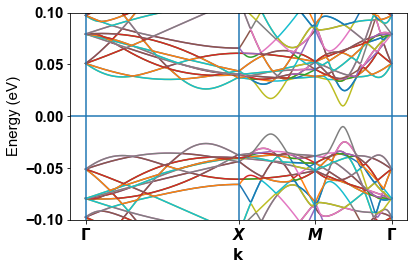

In [6]:
rc('font', size=15, family='arial', weight='bold')

k1=[[i, 0.5] for i in np.arange(0.5,1.01,0.005)]
t=[i for i in range(len(k1))]
Gammat=t[0]
Xt=t[-1]
k2=[[1.0, i] for i in np.arange(0.5,1.01,0.01)]
t.extend([t[-1]+i for i in range(len(k2))]) #Note, the end of k1 and beginning of k2 denotes the same pt in BZ
Mt=t[-1]
k3=[[i, i] for i in np.arange(0.5,1.01,0.01)]
k3.reverse()
t.extend([t[-1]+i for i in range(len(k3))])

k=k1+k2+k3

#This defines the three high-sym lines on square BZ. t enlists parametric
#def of the high-sym trajectory on BZ.

H=diag_H_BdG(k[0]) # This diag_H_BdG(k) is defined under the above section: My code to find individual Chern number
e=la1.eigh(H,eigvals_only=True)
Es=[np.copy(e)]

for i in range(1,len(k)):
    H=diag_H_BdG(k[i])
    e=la1.eigh(H,eigvals_only=True)
    e=[np.copy(e)]
    Es=np.vstack((Es,e))


for i in range(np.shape(Es)[1]):
    bandE=Es[:,i]
    #print(bandE)
    plt.plot(t,bandE)
    
    #print(min(bandE))

    
##################################################
#Minimum energy difference between consecutive energy eigenvalues at each k
band_diff=[]
for i in range(np.shape(Es)[0]):
    Enk=Es[i,:]
    diffE=np.array([abs(Enk[i]-Enk[i-1]) for i in range(1,len(Enk))])
    #print(k[i],np.where(diffE<10**(-6)))
    band_diff.append(np.min(diffE))
band_diff=np.array(band_diff)
#print(len(band_diff),len(np.where(band_diff<10**(-6))[0]))
##################################################
    
plt.xticks([Gammat,Xt,Mt,t[-1]],['$\Gamma$','$X$','$M$','$\Gamma$'])

plt.axhline(0.0)
plt.axvline(Gammat)
plt.axvline(Xt)
plt.axvline(Mt)
plt.axvline(t[-1])
plt.xlabel('$\mathbf{k}$')
plt.ylabel('Energy (eV)')
plt.ylim([-0.1,0.1])
plt.tight_layout()

#plt.savefig('twisted_bands2.png',dpi=500)

plt.show()